In [4]:
#!pip install pdfquery
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.3 MB/s eta 0:00:00


,Object,References
0,thm.31,18
1,thm.18,8
2,thm.27,7
3,thm.49,5
4,thm.35,4


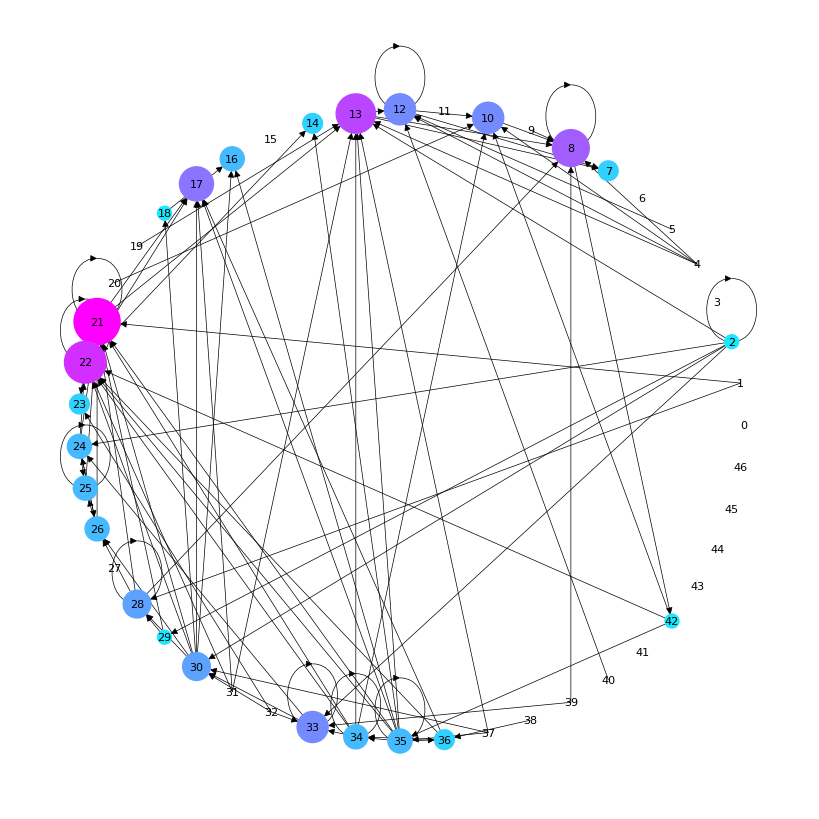

In [28]:
import re
import fitz
import matplotlib.pyplot as plt
import pandas as pd

# load the pdf
doc = fitz.open("file.pdf")

def extract_dest(link):
  """
  Extract the name and kind (e.g. thm, corollary, section...) of the link destination
  """
  xref=link['xref']
  keys=doc.xref_get_keys(xref)

  if 'A' in keys:
    dest_name = re.search("<<\/D\((.*?)\)\/S\/GoTo>>", doc.xref_get_key(xref,'A')[1]).group(1)
  elif 'Dest' in keys:
    dest_name = doc.xref_get_key(xref,'Dest')[1]

  dest_kind=re.search("(.*?)\.(.*?.*)", dest_name).group(1)
  return dest_kind,dest_name


def extract_info_link(link,page):
    """
    Extract all the needed info from a given link and output the results as a dictionary
    """
    dest_kind, dest_name=extract_dest(link)
    if dest_name:
      link_info={
          "kind": dest_kind,
          "xref": link['xref'],
          "from_page": page,
          "to_page": link["page"],
          "from_point": link["from"],
          "to_point": link["to"]-1,
          "dest_name": dest_name}
    else:
      link_info=None
    return link_info

# Extract all the links in the pdf and create a dictionary with the corresponding info
links_dict=[]
for page in range(0,doc.page_count):
  links=doc[page].get_links()
  for link in links:
    #print(link)
    if link['kind']==1:
      links_dict.append(extract_info_link(link,page))

# Create the adjacency matrix of the file
import numpy as np
adj_matrix=np.zeros((doc.page_count,doc.page_count))
for link in links_dict:
  if link['kind']=='thm' or link['kind']=='theorem':
    adj_matrix[link['from_page'],link['to_page']]=1

# Create a graph from the adjacency matrix
import networkx as nx
graph = nx.from_numpy_array(adj_matrix,create_using=nx.DiGraph)
deg=dict(graph.in_degree)
# Draw the graph
plt.figure(figsize=(8,8))
nx.draw_circular(graph,node_size=[v*100 for v in deg.values()],width=0.5, node_color=list(deg.values()),cmap=plt.cm.cool,font_size=8, with_labels=True)

# Sort the results by a given centrality measure (e.g. degree)
counter={}
for link in links_dict:
  if link['kind']=='thm' or link['kind']=='theorem':
    if  link['dest_name'] in counter:
      counter[link['dest_name']]+=1
    else:
      counter[link['dest_name']]=1

results=pd.DataFrame(counter.items(), columns=['Object', 'References']).sort_values("References",ignore_index=True, ascending=False)
results.head()